<a href="https://colab.research.google.com/github/kathuman/AI-in-Supply-Chain/blob/main/200716_Simple_RL_SC_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is reinforcement learning?

Reinformcement learning is an area of machine learning that models agents that take actions in an environment and attempt to maximize a reward that they accumulate over time. It is therefore interested in optimizing the sequential decision making of these agents in a potentially complex environment. 

Along with Supervised and Unsupervised learning, Reinforcement learning is one of three basic machine learning paradigms.

The agent uses trial and error to discover a solution to the problem of maximizing the reward and minimizing the penalties it obtains depending on the decisions it takes.

The designer of a test environment and of the agent defines the the reward policy, this is the rules of the game, yet no hints or siggestions are given in the model about how to solve the problem. The agent will maximize the reward, first by performing random trials that gradually evolve to the use of sophisticated tactics. 

## Model Description

In order to exploe the use of reinforcement learning in supply chains I have implemented a model in Python which I develop here step by step.

This model consists of a single warehouse subject to a customer demand that has stochastic variability according to a probability distribution, for example Uniform beteen values a and b, U[a,b] The warehouse is therefore the decision making agent in this model.

### Reward

The objective of this warehouse is to maximize a reward, this is the revenue it obtains composed of income minus expenses.

The Reward experienced by this Warehouse is the total revenue, which consists of
    a.- Sales Price of the items sold
    b.- MINUS the holding cost of the Inventory
    c.- MINUS the penality for Customer Demand not met

### Actions

The warehouse holds inventory (no maximum, and held in whole quantities) and can take two actions:
    a.- Sell inventory to a customer
    b.- Receive inventory from its supplier 
The warehouse can only do one of this actions at a time.

### State    
The State of the model is the warehouse inventory level

## Model Development

### Required Libraries

We first identify the libraries that will be needed.

In [ ]:
import numpy as np      # Library required for matrix creation  and manipulation
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import time             # Library required to calculate execution time
import pandas as pd     # Library required to manipulate Dataframes with the model results
%matplotlib inline

np.set_printoptions(precision=2, suppress=True)

### Model parameters

The model has cost and price parameters that can be defined at the beginning of the model, and which will not substantially change when the model is executed.

In [ ]:
cost_inventory = 2     # The cost of holding inventory
purchase_price = 20    # The price at which the inventory is bought
sales_price = 50       # The proce at which the inventory is sold

The Warehouse has as many states as it has number of units. The number of units the warehouse will be able to contain is between 0 and max_state (Warehouse size). Also, the initial state (initial warehouse stock) will be a random number between 0 and max_state.

In [ ]:
max_state = 800
initial_state = np.random.randint(max_state)

R Matrix, the "reward structure matrix" is defined as a square matrix of size (max_state x max_state). It contains the rewards and therefore also defones the possible actions that can be taken. First we initialize the R Matrix, We then fill it with the reward values 
-The X and Y coordinates of the Matrix correspond to the initial and final values of the decision. 

For example, the R Matrix value at [20, 45] represents that the state is moving from 20 to 45, this means that 25 stock items have been added to the warehouse. Therefore the reward is negative and corresponding to the cost of purchasing the 25 new stock items PLUS the cost of maintaining the inventory at the beginning of the period. 


In [ ]:
R = np.matrix(np.zeros([max_state,max_state]))

for y in range(0, max_state):
    for x in range(0, max_state):
        R[x,y] = np.maximum((x-y)*sales_price,0)-np.maximum((y-x)*purchase_price,0)-x*cost_inventory
        
print('R: \n', R)

R: 
 [[     0.    -20.    -40. ... -15940. -15960. -15980.]
 [    48.     -2.    -22. ... -15922. -15942. -15962.]
 [    96.     46.     -4. ... -15904. -15924. -15944.]
 ...
 [ 38256.  38206.  38156. ...  -1594.  -1614.  -1634.]
 [ 38304.  38254.  38204. ...  -1546.  -1596.  -1616.]
 [ 38352.  38302.  38252. ...  -1498.  -1548.  -1598.]]


The Q matrix sapture the total future reward for an agent from a given state after a certain action, and it has the same dimensions than the R Matrix. It is initialized at the time of creation with random numbers.

In [ ]:
Q = np.matrix(np.random.random([max_state,max_state]))

The learning and discount processes are also given parameters

In [ ]:
learning_rate = 0.5
discount = 0.7
EPISODES = 10000 
STEPS = 100
Pepsilon_init = 0.8   # initial value for the decayed-epsilon-greedy method
Pepsilon_end = 0.1    # final value for the decayed-epsilon-greedy method

We now start defining the functions used. First a function to determine the available actions from which the next action can be chosen.

In [ ]:
def available_actions(state, customers):
    # The available actions are 
    #    a.- Meeting a customer requirement (going to s: state-order)
    #    b.- Buying Inventory from Supplier (going to s: state+purchase)
    purchase = np.arange(state, max_state) # Calculate all possible future states due to purchases from the current state
    # print('Purchase: ',purchase)
    new_customers_state =[]
    new_customers_state = [np.maximum(state-x,0) for x in customers] # calculate the possible states from customers in the current state
    # print('new_customers_state: ', new_customers_state)
    return np.concatenate((purchase,new_customers_state))    

Next, we define a function that chooses at random which action to be performed within the range of available actions. This function defines what will be the future action. There is a range of options which basically are:

1.   Always choose the action that has the maximum Q value for the current_state (exploit)

1.   Always choose a random action from the available actions for the current_state (explore)

1.   Alternate between exploit and explore with a certain probability (which may change over time)

The general recommnedation is to start exploring most of the time and gradually decrease exploration to maximize exploitation.

For this we use the decayed-epsilon-greedy method where epsilon is the probability that a random action is chosen.

In [ ]:
def sample_next_action(available_act, epsilon):
    # here we choose the type of next action to take. 1 for a random next action with probability epsilon 
    # and 0 for a greedy next action with probability (1-epsilon)
    random_action = np.random.binomial(n=1, p=epsilon, size=1)
    
    if random_action == 1:
        # This is the option for full exploration - always random
        # print('random action')
        next_action = int(np.random.choice(available_act, 1))
    else:
        # This is the option for full exploitation - always use what we know (Greedy method)
        # Choose the next actions from the available actions, and the one with the highest Q Value
        # print('greedy action')
        next_action = np.int(np.where(Q[current_state,] == np.max(Q[current_state,available_act]))[1])
    
    # This section just caluclates the amount that is being sold or purchsed, if at all
    if next_action < current_state:
        Qsale = current_state-next_action
        Qpurchase = 0
    else: 
        Qpurchase = next_action - current_state
        Qsale = 0
    return next_action, Qsale, Qpurchase

In [ ]:
def cost_inventory_backlog(current_state):
    if current_state<=0:
        return cost_backlog
    else:
        return cost_inventory

In [ ]:
# this function updates the Q matrix according to the path selected and the Q learning algorithm
def update(current_state, action):
    '''
    In this function we update the Q table with the formula that requires the following parameters
    a.- Q[current_state, action] = value to update. In this case, the action is the future state value we decided to take.
    b.- learning_rate = value between 0 and 1 indicating how much new information overrides old information.
    c.- R[current_state, action] = reward obtained when transitioning from current_state to future_state=action (in the case of our model)
    d.- max a for Q[future_state, a] = the max Q value of the possible actions in the future_state 
    '''
    
    max_index = np.where(Q[action,] == np.max(Q[action,]))[1] # index for the maximum Q value in the future_state
    # print('Q[action,]: \n', Q[action,])
    # print('Current State: ', current_state)
    # print('Action: ', action)
    # print('Max Index:', max_index)
    
    # just in case there are more than one maximums, in which case we choose one at random
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size=1))
    else:
        max_index = int(max_index)
    max_value = Q[action, max_index] # this is the maximum Q valuein the future state given the action that generates that maximum value
    
    # Q learning formula
    Q[current_state, action] = (1-learning_rate)*Q[current_state, action] + learning_rate*(R[current_state, action] + discount*max_value) 

![Image of QFormula](https://randomant.net/images/algorithm-behind-curtain-2/q_learning_algorithm.jpg)

## Training the simulation

In [ ]:
# Training

av_reward_dataset =[]
reward_step = [] 
total_reward = []
calculation_times = []

current_state = np.random.randint(0, int(Q.shape[0]))
epsilon = Pepsilon_init
epsilon_delta = (Pepsilon_init - Pepsilon_end)/EPISODES

for episode in range(EPISODES):
    # Initialize values for Step
    total_reward_episode = 0
    start_time = time.time()
    for step in range(STEPS):
        customers = []
        customers.append(np.random.randint(0,15))
        available_act = available_actions(current_state, customers)
        action = sample_next_action(available_act, epsilon)
        update(current_state, action[0])
        # record the states for the step
        # reward_step.append(R[current_state, action[0]])
        total_reward_episode += R[current_state, action[0]]
        # update the state for the next step
        current_state = action[0]
    # record the states for the Episode
    total_reward.append(total_reward_episode) # Total reward for the episode
    calculation_times.append(time.time()-start_time)
    # Update parameters for the next episode
    epsilon = Pepsilon_init - episode*epsilon_delta

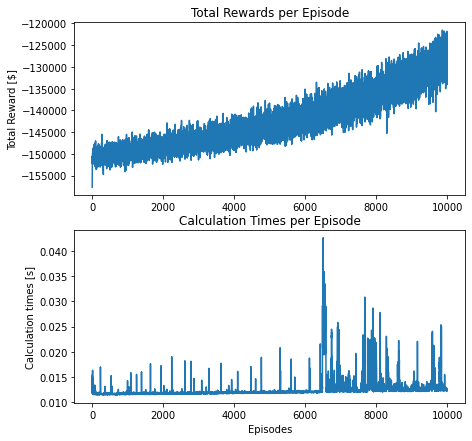

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
axs[0].plot(total_reward)
axs[0].set_title('Total Rewards per Episode')
axs[0].set_ylabel('Total Reward [$]')

axs[1].plot(calculation_times)
axs[1].set_title('Calculation Times per Episode')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Calculation times [s]')

plt.show()

In [ ]:
MA_total_reward = pd.DataFrame(total_reward)

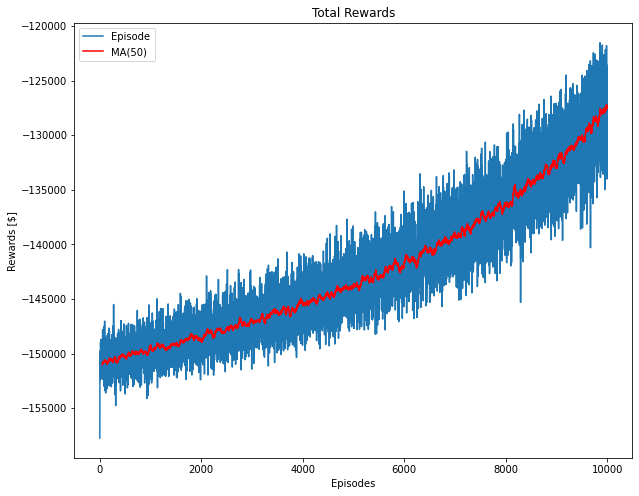

In [ ]:
Rolling_total_reward = MA_total_reward.rolling(window=50).mean()

plt.figure(figsize=(10,8))
plt.plot(MA_total_reward, label='Episode')
plt.plot(Rolling_total_reward, color='r', label ='MA(50)')
plt.title('Total Rewards')
plt.ylabel('Rewards [$]')
plt.xlabel('Episodes')
plt.legend()
plt.show()

## Test the simulation

In [ ]:
current_state = np.random.randint(0, int(Q.shape[0]))


3


In [ ]:
print(current_state)

6


In [ ]:
customers = []
customers.append(np.random.randint(0,15))
available_act = available_actions(current_state, customers)
print('Customers:', customers)
print('available_act: ', available_act)

Customers: [8]
available_act:  [6 7 8 9 0]


In [ ]:
epsilon = 0.1
action = sample_next_action(available_act, epsilon)
print('Action go to state {} from state {}, by Selling {} units and Purchasing {} units'.format(action[0], current_state, action[1],action[2]))

greedy action
Action go to state 7 from state 6, by Selling 0 units and Purchasing 1 units


In [ ]:
update(current_state, action[0])

current_state = action[0]

np.set_printoptions(precision=2, suppress=True)
print('Q: \n', Q)

Q[action,]: 
 [[0.23 0.79 0.53 0.14 0.76 0.3  0.2  0.28 0.14 0.36]]
Current State:  6
Action:  7
Max Index: [1]
Q: 
 [[  0.38   0.96   0.     0.35   0.76   1.     0.24   0.48   0.5    0.42]
 [  0.67   0.03   0.27   0.03   0.57   0.91   0.29   0.09   0.48   0.54]
 [  0.4    0.67   0.27   0.23   0.81   0.64   0.72   0.44   0.46   0.37]
 [  0.41   0.82   0.75   0.08  -6.38   0.6    0.11   0.6    0.14   0.75]
 [  0.66   0.39   0.8    0.62   0.16   0.16 -12.77   0.07   0.85   0.45]
 [  0.33   0.58   0.     0.3    0.56   0.61   0.97   0.62   0.5    0.57]
 [  0.37   0.61   0.24   0.05   0.6    0.6    0.72  -7.52   0.36   0.62]
 [  0.23   0.79   0.53   0.14   0.76   0.3    0.2    0.28   0.14   0.36]
 [  0.71   0.94   0.3    0.42   0.11   0.69   0.99   0.66   0.67   0.86]
 [  0.76   0.42   0.25   0.8    0.42   0.82   0.36   0.88   0.64   0.21]]


In [ ]:
print(action[0])

7
